In [1]:
# This notebook take UVES images numpy arrays and compute the resnet50 descriptors
# After that it save the descriptors in the descriptor blob in azure
from azure.storage.blob import BlockBlobService, PublicAccess

In [2]:
# Create the BlockBlockService that is used to call the Blob service 
# for the storage account
import config_blob_keys as cfg

account_name = cfg.AccountName
account_key = cfg.AccountKey
block_blob_service = BlockBlobService(account_name=account_name, account_key=account_key)

cont_name_analysis = cfg.ContNameAnalysis
block_blob_service.set_container_acl(cont_name_analysis, public_access=PublicAccess.Container)

cont_name_desc = cfg.ContNameDesc
block_blob_service.set_container_acl(cont_name_desc, public_access=PublicAccess.Container)

cont_name_desc_cor = cfg.ContNameDescCor
block_blob_service.set_container_acl(cont_name_desc_cor, public_access=PublicAccess.Container)

In [432]:
# Create a list "filelist" with the blob content
# inside the "Azure:container/folder" location 
def BlobList(container, folder, filelist, verbose=False):
    
    gen = block_blob_service.list_blobs(container, prefix=folder)
    
    for blob in gen:
        file = str(blob.name).replace(folder,'')
        filelist.append(file)
        if verbose == True:
            print("\t Blob name: " + blob.name)
        
    return filelist

# Download a file "blobfile" from "container" and save it 
# in the file "locfile"
def DownBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    
    block_blob_service.get_blob_to_path(container, blobfile, locfile)

    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    

# Uncompress data 
def UnCompress(file, verbose=False):
    
    if verbose == True:
        print('Uncompressing ' + file)
    
    subprocess.call(['uncompress', file])
    #os.popen('uncompress ' + file)

# Upload file "locfile" to the blob "blobfile" in container
def UpBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Uploading ' + locfile + ' to ' + blobfile)
        
    block_blob_service.create_blob_from_path(container, blobfile, locfile, validate_content=True)


In [433]:
# Funtions to visualize images maps and images histograms
def DisplayHist(imgood, imbad, verbose=False):

    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)
    im_mean = 0.5*(im_mean_g + im_mean_b)
    im_std = 0.5*(im_std_g + im_std_b)
    
    print("DMean: ", (im_mean_g-im_mean_b)/im_mean_g)
    print("DMedian: ", (im_median_g-im_median_b)/im_median_g)
    print("DStdDev: ", (im_std_g-im_std_b)/im_std_g)
        
    nbins = 100
    hist, bins, _ = plt.hist(np.ndarray.flatten(im_data_g), bins=nbins)
    plt.clf()
    #plt.figure(figsize=(10, 5))
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig, ax = plt.subplots(figsize=(8,4))
    plt.hist(np.ndarray.flatten(im_data_g), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Good')
    plt.hist(np.ndarray.flatten(im_data_b), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Bad')
    plt.legend()
    plt.title('Histogram')
    ax.set_yscale('log')
    plt.xscale('log')
    plt.xlabel('counts')
    plt.ylabel('# counts')
    plt.grid()
    plt.show()
    #fig.savefig(imnameb)
    
def DisplayMaps(imgood, imbad, verbose=False):
    
    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)    
    im_std = 0.5*(im_std_g + im_std_b)    
    
    fig, axrr = plt.subplots(1, 2, figsize=(10,12))
    #fig, ax = plt.subplots(figsize=(3,4))
    im = axrr[0].imshow(im_data_g, origin='lower', interpolation='nearest', vmin=im_median_g-im_std_g, vmax=im_median_g+2*im_std_g, cmap='Greys_r')
    axrr[0].set_title('Good')
    plt.tight_layout()
    axrr[0].set_xlabel('x')
    axrr[0].set_ylabel('y')

    #plt.subplot(1, 2, 2)
    #fig, ax = plt.subplots(figsize=(3,4))
    #fig, axrr = plt.subplots(1, 2, figsize=(16,8))
    im = axrr[1].imshow(im_data_b, origin='lower', interpolation='nearest', vmin=im_median_b-im_std_b, vmax=im_median_b+2*im_std_b, cmap='Greys_r')
    axrr[1].set_title('Bad')
    plt.tight_layout()
    axrr[1].set_xlabel('x')
    axrr[1].set_ylabel('y')
    
    plt.show()
    #fig.savefig(imnamea)

In [434]:
import pandas as pd
import numpy as np
import utils_blob as ub
import os
import multiprocessing
import tqdm
import time
import random
import matplotlib.pyplot as plt

from functools import partial

In [520]:
npool = 4
nsample = 20

method1_dir = 'numpy/method1'
method2_dir = 'numpy/method2'
method3_dir = 'numpy/method3'

random.seed(101)

# Define the subdirs to be created in /descriptor based on the image type and ext
#npyBlobSubDirs = ['UVES_BLUE_BIAS','UVES_RED_BIAS','UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
#npyBlobSubDirs = ['UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
# Test
save_image = True
select_year = True
year = '2017'
desc_name = []
DescBlobSubDirs = ['UVES_BLUE_BIAS']
UVES_imtype = 'UVES_BLUE_BIAS'
path_loc = '../Temp/test'

# Loof for images type folder
for desc_blob_sub_dir in DescBlobSubDirs:
    # Images extensions
    
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        Exten = [0]
    elif desc_blob_sub_dir == 'UVES_RED_BIAS' or desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        Exten = [1]#,2]
    
    # Define the image type
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS':
        image_type = 'bias_blue'
    elif desc_blob_sub_dir == 'UVES_RED_BIAS':
        image_type = 'bias_red'
    elif desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        image_type = 'blue_arc_flat'
    elif desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        image_type = 'red_arc_flat'

    # Take bad image names
    PROJECT_DIR = "/data/notebooks/uves_jprieto"
    DATA_DIR = os.path.join(PROJECT_DIR, "data")
    
    uves_flag_file=os.path.join(DATA_DIR, 'UVES_hidden_flag_results.txt')
    uves_flag_df=pd.read_csv(uves_flag_file, comment='#', sep=';')
    #uves_flag_df['filename'] = uves_flag_df['filename']+'.fits'
    corrupted_df = uves_flag_df[(uves_flag_df['image_type'] == image_type) & (uves_flag_df['flag'] == 'CORRUPTED')]
    bad_files_garchim = list(corrupted_df['filename']) 
    
    # Loop for images extensions
    for ext in Exten:
        extension = 'ext'+str(ext)
        print('Working on ' + desc_blob_sub_dir + ' extension ' + extension + '...\n')
        
        # Bad Garchim images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method1_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_cor_list = []
        desc_files_list = [s for s in desc_files_list if any(xs in s for xs in bad_files_garchim)]
        
        if len(desc_files_list) >= nsample:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badg_files = desc_files_list
        
        # Good images method1
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method1_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_files_list = [s for s in desc_files_list if s not in bad_files_garchim]
        if select_year==True:
            desc_files_list = [s for s in desc_files_list if year in s]
            desc_files_list = random.sample(desc_files_list, nsample)
        elif select_year==False:
            desc_files_list = random.sample(desc_files_list, nsample)
        #desc_files_list = random.sample(desc_files_list, nsample)
        desc_good1_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        im_abr = []
        print('Good images method 1...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = 'M1-' + str(idx)
                im_abr.append(name)
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_good1 = np.delete(desc_matrix,0,axis=0)
        desc_name.append(im_abr)
        
        # Good images method2
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method2_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_files_list = [s for s in desc_files_list if s not in bad_files_garchim]
        if select_year==True:
            desc_files_list = [s for s in desc_files_list if year in s]
            desc_files_list = random.sample(desc_files_list, nsample)
        elif select_year==False:
            desc_files_list = random.sample(desc_files_list, nsample)
        #desc_files_list = random.sample(desc_files_list, nsample)
        desc_good2_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        im_abr = []
        print('Good images method 2...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = 'M2-' + str(idx)
                im_abr.append(name)
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_good2 = np.delete(desc_matrix,0,axis=0)
        desc_name.append(im_abr)
        
        # Good images method3
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method3_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_files_list = [s for s in desc_files_list if s not in bad_files_garchim]
        if select_year==True:
            desc_files_list = [s for s in desc_files_list if year in s]
            desc_files_list = random.sample(desc_files_list, nsample)
        elif select_year==False:
            desc_files_list = random.sample(desc_files_list, nsample)
        #desc_files_list = random.sample(desc_files_list, nsample)
        desc_good3_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        im_abr = []
        print('Good images method 3...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = 'M3-' + str(idx)
                im_abr.append(name)
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_good3 = np.delete(desc_matrix,0,axis=0)
        desc_name.append(im_abr)

Working on UVES_BLUE_BIAS extension ext0...

Good images method 1...



Good images method 2...



Good images method 3...


In [521]:
M1names  = desc_name[0]
M2names  = desc_name[1]
M3names  = desc_name[2]

files_M1 = desc_good1_files
files_M2 = desc_good2_files
files_M3 = desc_good3_files

In [522]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Parameters for clustering
norm = True
method = 'single'
metric = 'cosine'
criterion = 'distance'

# Normalize vectors of the matrix
if norm == True:
    desc_good1 = normalize(desc_good1)
    desc_good2 = normalize(desc_good2)
    desc_good3 = normalize(desc_good3)

desc_mat = np.vstack((desc_good1,desc_good2,desc_good3))
names = M1names + M2names + M3names

# Create the distance matrix
if metric == 'cosine':
    sim_mat   = cosine_similarity(desc_mat)
    sim_good1 = cosine_similarity(desc_good1)
    sim_good2 = cosine_similarity(desc_good2)
    sim_good3 = cosine_similarity(desc_good3)
elif metric == 'euclidean':
    sim_mat   = euclidean_distances(desc_mat)
    sim_good1 = euclidean_distances(desc_good1)
    sim_good2 = euclidean_distances(desc_good2) 
    sim_good3 = euclidean_distances(desc_good3) 

In [523]:
'''
# Plot distance similarity matrix
df_sim = pd.DataFrame(sim_mat)

fig, ax = plt.subplots(figsize=(8, 16))
cax = ax.matshow(df_sim, cmap='RdYlGn')#, vmin=0.5)
plt.xticks(range(len(df_sim.columns)), df_sim.columns, rotation=90);
plt.yticks(range(len(df_sim.columns)), df_sim.columns);
cbar = fig.colorbar(cax, aspect=50, shrink=0.5)
cbar.set_label('Cosine similarity', rotation=90)
fig.show()
#fig.savefig('CosineSimilarity.png')
'''

"\n# Plot distance similarity matrix\ndf_sim = pd.DataFrame(sim_mat)\n\nfig, ax = plt.subplots(figsize=(8, 16))\ncax = ax.matshow(df_sim, cmap='RdYlGn')#, vmin=0.5)\nplt.xticks(range(len(df_sim.columns)), df_sim.columns, rotation=90);\nplt.yticks(range(len(df_sim.columns)), df_sim.columns);\ncbar = fig.colorbar(cax, aspect=50, shrink=0.5)\ncbar.set_label('Cosine similarity', rotation=90)\nfig.show()\n#fig.savefig('CosineSimilarity.png')\n"

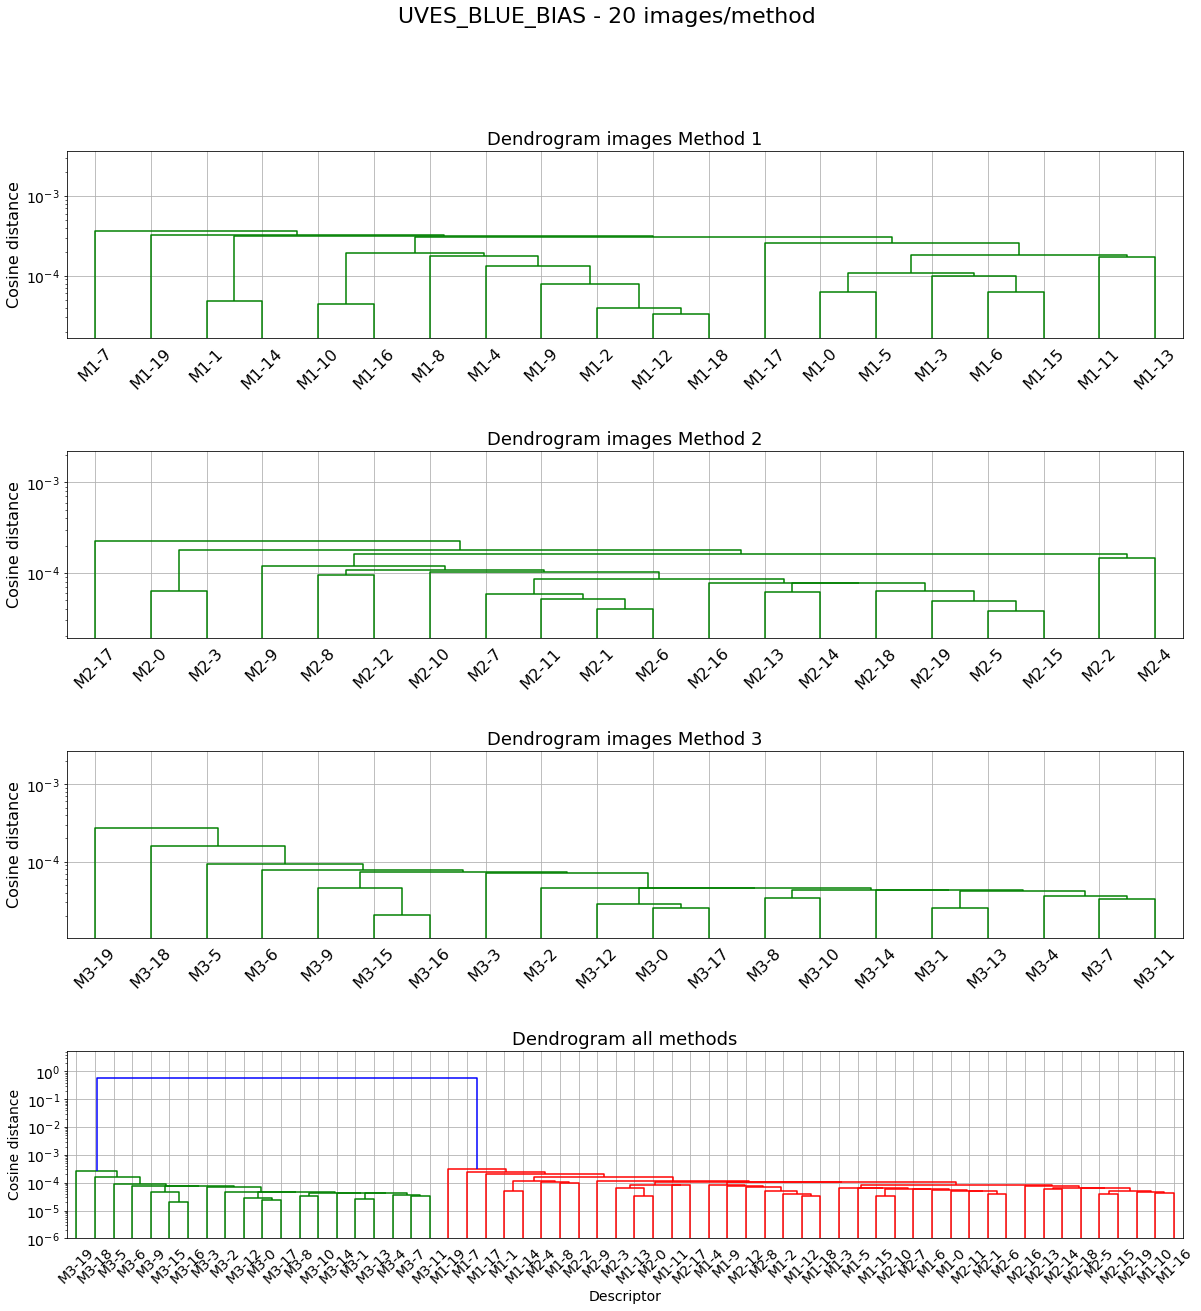

In [524]:
# For the parameters defined above create the desdrograms 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#good_desc_mat = np.delete(good_desc_mat,29,axis=0)
#good_desc_mat = np.delete(good_desc_mat,2,axis=0)

hspace = 0.6

fig = plt.figure(figsize=(20,20))
fig.suptitle('%s - 20 images/method' % UVES_imtype, fontsize=22)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=hspace)
plt.subplot(411)
plt.title("Dendrogram images Method 1", fontsize=18)  
Z = sch.linkage(desc_good1, method=method, metric=metric)
thresh = 1.01*Z[desc_good1.shape[0]-2,2]
ymax = 10.0*Z[desc_good1.shape[0]-2,2]
ymin = 0.5*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=thresh, labels=M1names, leaf_rotation=45)
plt.ylabel('Cosine distance', fontsize=16)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylim((ymin,ymax))
plt.grid()

plt.subplot(412)
plt.title("Dendrogram images Method 2", fontsize=18)  
Z = sch.linkage(desc_good2, method=method, metric=metric)
thresh = 1.01*Z[desc_good2.shape[0]-2,2]
ymax = 10.0*Z[desc_good2.shape[0]-2,2]
ymin = 0.5*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=thresh, labels=M2names, leaf_rotation=45)
#plt.xlabel('Descriptor', fontsize=14)
plt.ylabel('Cosine distance', fontsize=16)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylim((ymin,ymax))
plt.grid()

plt.subplot(413)
plt.title("Dendrogram images Method 3", fontsize=18)  
Z = sch.linkage(desc_good3, method=method, metric=metric)
thresh = 1.01*Z[desc_good3.shape[0]-2,2]
ymax = 10.0*Z[desc_good3.shape[0]-2,2]
ymin = 0.5*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=thresh, labels=M3names, leaf_rotation=45)
plt.ylabel('Cosine distance', fontsize=16)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylim((ymin,ymax))
plt.grid()

#plt.figure(figsize=(12,10))  
#plt.figure(4)
plt.subplot(414)
plt.title("Dendrogram all methods", fontsize=18)  
Z = sch.linkage(desc_mat, method=method, metric=metric)
thresh = 0.05
ymax = 10.0*Z[desc_mat.shape[0]-2,2]
ymin = 0.05*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=thresh, labels=names, leaf_rotation=45)
plt.xlabel('Descriptor', fontsize=14)
plt.ylabel('Cosine distance', fontsize=14)
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim((ymin,ymax))
plt.grid()

plt.show()
if save_image == True:
    fig.savefig('DenCompMeth_123_%s.png' % UVES_imtype)

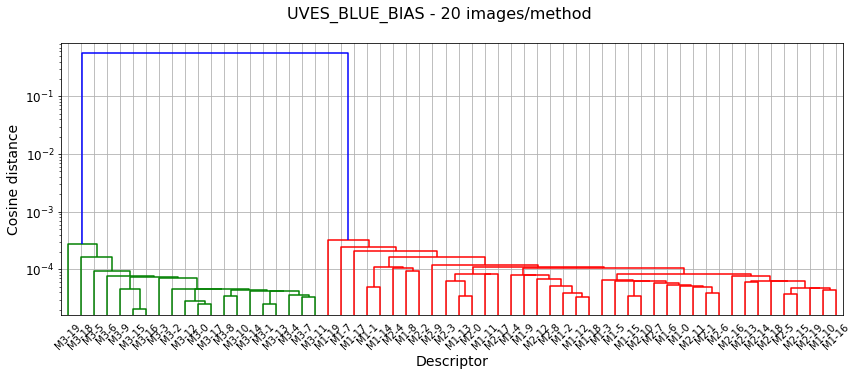

In [533]:
# For the parameters defined above create the desdrograms 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#good_desc_mat = np.delete(good_desc_mat,29,axis=0)
#good_desc_mat = np.delete(good_desc_mat,2,axis=0)

hspace = 0.6

fig = plt.figure(figsize=(14,5))
fig.suptitle('%s - 20 images/method' % UVES_imtype, fontsize=16)

#plt.title("Dendrogram all methods", fontsize=18)  
Z = sch.linkage(desc_mat, method=method, metric=metric)
thresh = 0.05
ymax = 1.5*Z[desc_mat.shape[0]-2,2]
ymin = 0.8*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=thresh, labels=names, leaf_rotation=45)
plt.xlabel('Descriptor', fontsize=14)
plt.ylabel('Cosine distance', fontsize=14)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.ylim((ymin,ymax))
plt.grid()

plt.show()
if save_image == True:
    fig.savefig('DenCompMeth_123_%s.png' % UVES_imtype)

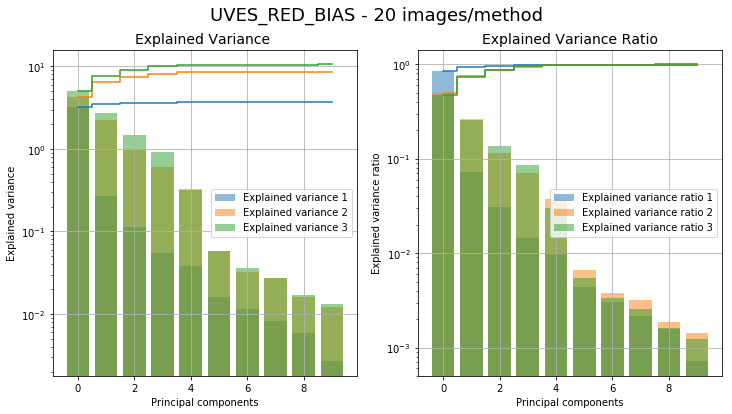

In [440]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

#plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
fig.suptitle('%s - 20 images/method' % UVES_imtype, fontsize=18)
ncomp = 10

svd1 = TruncatedSVD(n_components=ncomp)
svd1.fit(desc_good1)
expl_var1 = svd1.explained_variance_
expl_var1 =sorted(expl_var1, reverse=True)
expl_var1_rat = svd1.explained_variance_ratio_
expl_var1_rat =sorted(expl_var1_rat, reverse=True)

svd2 = TruncatedSVD(n_components=ncomp)
svd2.fit(desc_good2)
expl_var2 = svd2.explained_variance_
expl_var2 =sorted(expl_var2, reverse=True)
expl_var2_rat = svd2.explained_variance_ratio_
expl_var2_rat =sorted(expl_var2_rat, reverse=True)

svd3 = TruncatedSVD(n_components=ncomp)
svd3.fit(desc_good3)
expl_var3 = svd3.explained_variance_
expl_var3 =sorted(expl_var3, reverse=True)
expl_var3_rat = svd3.explained_variance_ratio_
expl_var3_rat =sorted(expl_var3_rat, reverse=True)

#print("\n\nExplained Variance ",explained_variance)
#print("\n\nExplained Variance Ratio  ", explained_variance_ratio)
#print("\n\nCummulative Sum  ", np.cumsum(svd.explained_variance_))
#print("\n\nExplained Variance Ratio Sum ",svd.explained_variance_ratio_.sum())  
#print("\n\nSingular Values ",svd.singular_values_)
 
plt.subplot(1, 2, 1)
plt.bar(range(ncomp), expl_var1, alpha=0.5, align='center', label='Explained variance 1')
plt.bar(range(ncomp), expl_var2, alpha=0.5, align='center', label='Explained variance 2')
plt.bar(range(ncomp), expl_var3, alpha=0.5, align='center', label='Explained variance 3')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title("Explained Variance ", fontsize=14)
plt.grid()
plt.yscale('log')
plt.step(range(ncomp), np.cumsum(expl_var1), where='mid',label='cumulative explained variance')
plt.step(range(ncomp), np.cumsum(expl_var2), where='mid',label='cumulative explained variance') 
plt.step(range(ncomp), np.cumsum(expl_var3), where='mid',label='cumulative explained variance')
    
plt.subplot(1, 2, 2)
plt.bar(range(ncomp), expl_var1_rat, alpha=0.5, align='center', label='Explained variance ratio 1')
plt.bar(range(ncomp), expl_var2_rat, alpha=0.5, align='center', label='Explained variance ratio 2')
plt.bar(range(ncomp), expl_var3_rat, alpha=0.5, align='center', label='Explained variance ratio 3')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title("Explained Variance Ratio", fontsize=14)
plt.grid()
plt.yscale('log')
plt.step(range(ncomp), np.cumsum(expl_var1_rat), where='mid',label='cumulative explained variance')
plt.step(range(ncomp), np.cumsum(expl_var2_rat), where='mid',label='cumulative explained variance')
plt.step(range(ncomp), np.cumsum(expl_var3_rat), where='mid',label='cumulative explained variance')
plt.show()
if save_image == True:
    fig.savefig('SVDMeth%s.png' % UVES_imtype)